# Numerisches Rechnen mit Python

M. Sc. Roy Morgenstern

Institut für Geotechnik

TU Bergakademie Freiberg

<!-- ![logo_feme](logo_feme.png) -->
<img src="./images/Logo_FM_neu.png" alt="Logo FEME" width="200">

## Numerisches Rechnen

Lösen von DGL oder Matrizenrechnung mittels eines Computers durch numerische Näherungsverfahren.

**Umsetzung in Python:**

* Modul importieren `import numpy as np`
* `import scipy as sp` das Modul **Scipy** bietet erweiterte Funktionalität
* **Numpy** bietet Arrays und entsprechende Funktionen die ***elementweise*** operieren
* **Numpy** unterstützt *Slicing* von Arrays (vgl. **MATLAB**)
* beispielsweise:
    * num. differenuieren: `np.diff`
    * `np.min`, `np.max`, `np.sin`, `np.cos`, `np.abs`, ...
    * Matrixmultiplikation: `np.dot(a, b)`
    * Lineare Algebra in `np.linalg` (`np.linalg.norm`, ...)

Siehe auch Numpy-Referenz [https://docs.scipy.org/doc/numpy/reference/index.html](https://docs.scipy.org/doc/numpy/reference/index.html)

**Scipy**

* bietet erweiterte Funktionalität
* setzt auf **Numpy** auf (arbeitet mit Numpy-Arrays)
* Dateiein- und Ausgabe (bsp. .mat-Format) `scipy.io`
* Signalverarbeitung (FFT, Filter, ...) `scipy.signal`
* Interpolation und Optimierung `scipy.interpolate` und `scipy.optimize`
* Statistik `scipy.stats`

Siehe auch Scipy-Referenz: [https://docs.scipy.org/doc/scipy/reference/](https://docs.scipy.org/doc/scipy/reference/)



### Programmierübung `Filter`

Das Filtern von Datensätzen gehört im wissenschaftlichen Ablauf zu den Standardaufgaben. Daher soll in dieser Übung gezeigt werden, wie man entsprechende gestörte Signale über
geschickt konstruierte Filter wiederherstellen kann. In der vorangegangenen Übung wurden die Bewegungsgleichungen eines mechanischen Systems mit einem Freiheitsgrad hergeleitet. Im Rahmen dieser Übung wird dieses System nun mittels **Numpy** numerisch simuliert. Hierbei wird das System zunächst durch Rauschen gestört, welches nachfolgend über entsprechende Filteroperationen wieder entfernt werden soll.

In [82]:
# module laden
import numpy as np
import pylab as pl  # das Nötigste von Matplotlib

# einige wichtige Funktionen aus scipy laden
from scipy.io import savemat, loadmat
from scipy.signal import butter, filtfilt, lfilter

# die lagrange-Funktion aus sympy_pendel.py importieren
from sympy_pendel import lagrange

def simulate_measurement(F, A0, tend):
    phit_f, phidt_f, phiddt_f = lagrange()
    
    t = np.linspace(0, tend, 1000)  # Zeitvektor t anlegen
    phi = phit_f(A0, 2*np.pi*F, t)
    phidt = phidt_f(A0, 2*np.pi*F, t)
    phiddt = phiddt_f(A0, 2*np.pi*F, t)
    
    # Rauschen
    err = np.random.uniform(-1, 1, len(t)) * 0.25*A0  # Rauschen mit einer Magnitude von 25%
    gest = phi + err
    
    # speichern als .mat-Datei --> Interoperabilität
    sdict = {'t': t, 'phi': phi,
             'phidt': phidt, 'phiddt': phiddt,
             'gest': gest}
    savemat('results.mat', sdict)
    
simulate_measurement(2.0, 4.5, 1)



Lagrange-Funktion:
                                            2
                              2   ⎛d       ⎞ 
-g⋅l⋅m⋅(1 - cos(φ(t))) + 0.5⋅l ⋅m⋅⎜──(φ(t))⎟ 
                                  ⎝dt      ⎠ 
Euler-Lagrange-Funktion:
                             2      
                       2    d       
g⋅l⋅m⋅sin(φ(t)) + 1.0⋅l ⋅m⋅───(φ(t))
                             2      
                           dt       
Kleinwinkelnäherung:
                        2      
                  2    d       
g⋅l⋅m⋅φ(t) + 1.0⋅l ⋅m⋅───(φ(t))
                        2      
                      dt       
Allgemeine Lösung:
φ(t) = C₁⋅sin(1.0⋅ω⋅t) + C₂⋅cos(1.0⋅ω⋅t)
allgemeine Gl.:
C₁⋅sin(1.0⋅ω⋅t) + C₂⋅cos(1.0⋅ω⋅t)
allgemeine Abl.:
1.0⋅C₁⋅ω⋅cos(1.0⋅ω⋅t) - 1.0⋅C₂⋅ω⋅sin(1.0⋅ω⋅t)
Spezielle Lösung:
φ(t) = A⋅cos(1.0⋅ω⋅t)


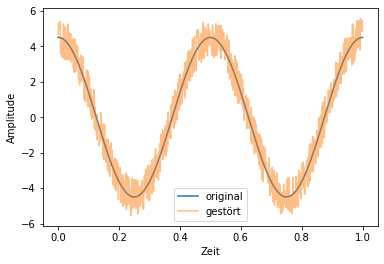

In [83]:
# Daten laden und anzeigen
di = loadmat('results.mat')

# Datensätze entpacken
t = di['t'][0]
ori = di['phi'][0]  # normalerweise unbekannt
sig = di['gest'][0]

# Daten plotten
pl.figure()
pl.plot(t, ori, label='original')
pl.plot(t, sig, label='gestört', alpha=.5)
pl.xlabel('Zeit')
pl.ylabel('Amplitude')
pl.legend()

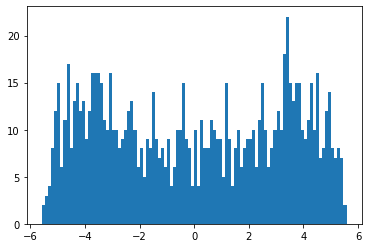

In [84]:
# Schauen wir uns das Rauschen an
pl.figure()
_ = pl.hist(sig, bins=100)

In [85]:
# FFT generell besser geeignet
phif = np.fft.fft(ori)
gesf = np.fft.fft(sig)

L = len(phif)//2 + 1
dt = t[1] - t[0] # Samplingrate
fs = 1/dt # Samplingfrequenz
fny = fs/2 # Nyquist-Frequenz

freq = np.linspace(0, fny, L)

print('Sampleinterval  : %.6fs' % dt)
print('Samplingfrequenz: %.2fHz' % fs)
print('Nyquist-Frequenz: %.2fHz' % fny)

Sampleinterval  : 0.001001s
Samplingfrequenz: 999.00Hz
Nyquist-Frequenz: 499.50Hz


Text(0, 0.5, '|A|')

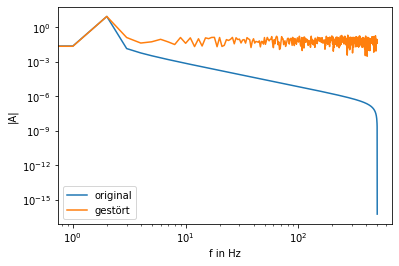

In [86]:
# Amplitudenspektrum
pl.figure()
pl.loglog(freq, 2/L*np.abs(phif[:L]), label='original')
pl.loglog(freq, 2/L*np.abs(gesf[:L]), label='gestört')
pl.legend()
pl.xlabel('f in Hz')
pl.ylabel('|A|')

Text(0, 0.5, 'A')

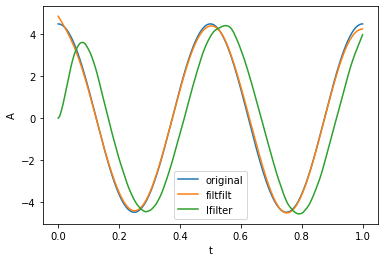

In [98]:
# Konstruiere Butterworth-Lowpass-Filter
Fcut = 6.0 # Cutoff Frequenz
Wn = Fcut/fny
b, a = butter(2, Wn, btype='low')

gef1 = filtfilt(b, a, sig)
gef2 = lfilter(b, a, sig)

pl.figure()
pl.plot(t, ori, label='original')
pl.plot(t, gef1, label='filtfilt')
pl.plot(t, gef2, label='lfilter')
pl.legend()
pl.xlabel('t')
pl.ylabel('A')

Text(0, 0.5, '|A|')

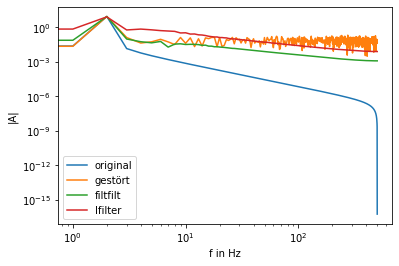

In [99]:
# Schauen wir uns das gefilterte Spektrum noch einmal an
gef1f = np.fft.fft(gef1)
gef2f = np.fft.fft(gef2)

# Amplitudenspektrum
pl.figure()
pl.loglog(freq, 2/L*np.abs(phif[:L]), label='original')
pl.loglog(freq, 2/L*np.abs(gesf[:L]), label='gestört')
pl.loglog(freq, 2/L*np.abs(gef1f[:L]), label='filtfilt')
pl.loglog(freq, 2/L*np.abs(gef2f[:L]), label='lfilter')
pl.legend()
pl.xlabel('f in Hz')
pl.ylabel('|A|')

## Übungsaufgabe `Lineare Ausgleichsrechnung`

Gegeben sind Messdaten $(t_i, y_i)_{i=1,...,4}$ eines hier nicht näher spezifizierten Systems. Es wird angenommen, dass diese Daten der Beziehung

$$y = f(t) = \alpha \frac{1}{1+t}+\beta$$

genügen.

Über eine lineare Ausgleichsrechnung lassen sich nun die Parameter $\alpha$ und $\beta$ anhand der Messdaten bestimmen. Im Beispiel wird die Ausgleichsrechnung auf das Lösen der
Normalengleichungen zurückgeführt.

**Normalengleichungen**:

$$A^TAx = A^Ty$$

mit Lösungsvektor $x$, rechter Seite $y$ und Koeffizentenmatrix $A$.

Text(0, 0.5, 'y')

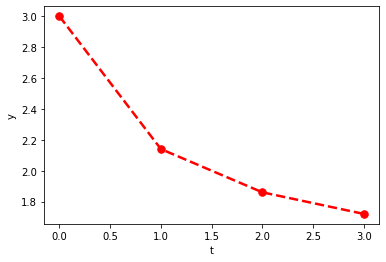

In [102]:
# benötigte Module importieren
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # Ausgleichsrechnung von scipy als vergleich

# Daten laden
t, y = np.loadtxt('messung.dat', delimiter=',', skiprows=1, unpack=True)

# Daten anzeigen
plt.figure()
plt.plot(t, y, 'r--', lw=2.5, marker='.', ms=15)
plt.xlabel('t')
plt.ylabel('y')

In [105]:
# zu bestimmende parameter alpha und beta
# Matrix anlegen (size(A) = (Anzahl Daten, Anzahl Parameter))

A = np.ones((len(t), 2))

A[:, 0] = 1/(1+t)

# Normalengleichungen
rhs = np.dot(A.T, y)
lhs = np.dot(A.T, A)
x = np.dot(np.linalg.inv(lhs), rhs)
alpha, beta = x

print('alpha = %.3f\nbeta = %.3f' % (alpha, beta))

alpha = 1.708
beta = 1.290


Text(0, 0.5, 'y')

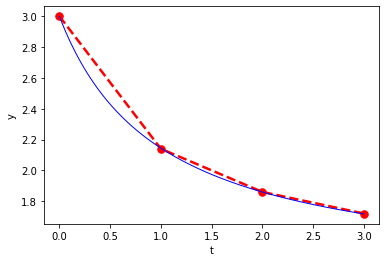

In [106]:
tn = np.linspace(min(t), max(t), 100)
fm = alpha*1/(1+tn) + beta

plt.figure()
plt.plot(t, y, 'r--', lw=2.5, marker='.', ms=15)
plt.plot(tn, fm, 'b-', lw=1.0)
plt.xlabel('t')
plt.ylabel('y')

In [111]:
# Curve-Fitting aus scipy
ft = lambda t, a, b: a*1/(1+t) + b

popt, pcov = curve_fit(ft, t, y)
alpha_c, beta_c = popt

print('alpha = %.8f (%.8f)\nbeta = %.8f (%.8f)' % (alpha_c, alpha, beta_c, beta))

alpha = 1.70830769 (1.70830769)
beta = 1.29025641 (1.29025641)
